# Step 1 : merging gas prices files. 

Here we import all libraries and tools for the project. 

In [1]:
import pyspark

In [2]:
import os

In [3]:
import pandas as pd
import numpy as np
import glob
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

C:\Users\romai\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
sc = pyspark.SparkContext()

In [ ]:
sc._conf.getAll()

In [ ]:
sqlsc = pyspark.SQLContext(sc)

In [ ]:
spark = sqlsc.sparkSession

We load all price's dataframes from 2015 to 2018.

In [ ]:
prix15_df = spark.read.load(r'C:\Users\romai\Documents\Prix2015.csv', format='csv', sep=';', header='false', inferSchema='true')

In [9]:
prix16_df = spark.read.load(r'C:\Users\romai\Documents\Prix2016.csv', format='csv', sep=';', header='false', inferSchema='true')

In [10]:
prix17_df = spark.read.load(r'C:\Users\romai\Documents\Prix2017.csv', format='csv', sep=';', header='false', inferSchema='true')

In [11]:
prix18_df = spark.read.load(r'C:\Users\romai\Documents\Prix2018.csv', format='csv', sep=';', header='false', inferSchema='true')

We then merge files to create a more general one.

In [12]:
prix_df=prix15_df.union(prix16_df).union(prix17_df).union(prix18_df)

In [12]:
prix_df.show(5)

+-------+----+---+---------+--------+-------------------+---+------+----+
|    _c0| _c1|_c2|      _c3|     _c4|                _c5|_c6|   _c7| _c8|
+-------+----+---+---------+--------+-------------------+---+------+----+
|1000001|1000|  R|4620114.0|519791.0|2015-01-02 11:01:45|  1|Gazole|1141|
|1000001|1000|  R|4620114.0|519791.0|2015-01-03 09:01:42|  1|Gazole|1141|
|1000001|1000|  R|4620114.0|519791.0|2015-01-07 10:01:44|  1|Gazole|1141|
|1000001|1000|  R|4620114.0|519791.0|2015-01-08 10:01:06|  1|Gazole|1115|
|1000001|1000|  R|4620114.0|519791.0|2015-01-09 10:01:19|  1|Gazole|1115|
+-------+----+---+---------+--------+-------------------+---+------+----+
only showing top 5 rows



In [13]:
from pyspark.sql.functions import to_date, date_format

We split date in, year, month, week. 

In [14]:
prix_df = prix_df.withColumn("year", date_format(to_date("_c5", "yyyy-MM-dd"), "y"))
prix_df = prix_df.withColumn("month", date_format(to_date("_c5", "yyyy-MM-dd"), "M"))
prix_df = prix_df.withColumn("week", date_format(to_date("_c5", "yyyy-MM-dd"), "w"))

In [15]:
prix_df = prix_df.selectExpr(
    '_c0 as id_station', 
    '_c1 as zipcode',
    '_c2 as type_pop',
    '_c3/100000 as latitude',
    '_c4/100000 as longitude',
    '_c5 as date',
    '_c6 as gas_type',
    '_c7 as gas_label',
    '_c8/1000 as price',
    'year',
    'month',
    'week'
)

In [17]:
prix_df.filter(prix_df["latitude"].isNull()).count()

5140

In [16]:
sqlsc.registerDataFrameAsTable(prix_df, 'table_prix')

In [18]:
sqlsc.sql('SELECT count(*) FROM table_prix').show()

+--------+
|count(1)|
+--------+
| 8308360|
+--------+



# Step 2 : deduplicating stations.

We import stations files and merge them.

In [17]:
stations16_df = spark.read.load(r'C:\Users\romai\Documents\Stations2016.csv', format='csv', 
                               sep='|', header='false', inferSchema='true', PYTHONIOENCODING='utf-8')

In [18]:
stations17_df = spark.read.load(r'C:\Users\romai\Documents\Stations2017.csv', format='csv', 
                               sep='|', header='false', inferSchema='true', PYTHONIOENCODING='utf-8')

In [19]:
stations18_df = spark.read.load(r'C:\Users\romai\Documents\Stations2018.csv', format='csv', 
                               sep='|', header='false', inferSchema='true', PYTHONIOENCODING='utf-8')

In [20]:
stations_df=stations16_df.union(stations17_df).union(stations18_df)

In [21]:
stations_df = stations_df.selectExpr(
    '_c0 as id_station', 
    '_c1 as zipcode',
    '_c2 as type_pop',
    '_c3/100000 as latitude',
    '_c4/100000 as longitude',
    '_c5 as address',
    '_c6 as city',
)

In [22]:
stations_df.filter(stations_df["latitude"].isNull()).count()

238

In [23]:
stations_df.filter(stations_df["address"].isNull()).count()

0

In [24]:
stations_df.filter(stations_df["longitude"].isNull()).count()

235

In [25]:
stations_df = stations_df.filter(stations_df.latitude.isNotNull())

In [26]:
stations_df = stations_df.filter(stations_df.longitude.isNotNull())

In [27]:
stations_df.filter(stations_df["latitude"].isNull()).count()

0

In [28]:
stations_df.filter(stations_df["longitude"].isNull()).count()

0

In [29]:
stations_df.count()

We deduplicate stations based on location.

In [30]:
stations_df = stations_df.dropDuplicates(['latitude', 'longitude', 'id_station'])

We group by stations by selected deduplication keys and generate a unique ID.

In [31]:
unique_df = stations_df.groupBy(['latitude','longitude']).agg({'id_station' : 'max'})

In [32]:
unique_df = unique_df.select(pyspark.sql.functions.col("latitude").alias("latitude"), pyspark.sql.functions.col("longitude").alias("longitude"), 
                         pyspark.sql.functions.col("max(id_station)").alias("id_unique"))

In [34]:
unique_df.show()

+------------------+-------------------+---------+
|          latitude|          longitude|id_unique|
+------------------+-------------------+---------+
|          48.53901|           -2.98844| 22170003|
|          5.672E-5|          4.6325E-4|  1590002|
|          44.91366|            4.44244|  7160003|
|            48.978|              6.026| 54530002|
|          45.00888|0.15155000000003999| 24700001|
|            46.973|             -2.239| 85680001|
|     43.7043567908|      1.80005500095| 81500004|
|       49.06503644|        -1.19698905| 50750001|
|          43.21566|             2.3546| 11000012|
|          43.41718|            6.77602| 83700007|
|          46.56141|            0.31494| 86000013|
|50.483911375599995|      2.40352097875| 62550001|
|            43.293|              0.515| 65230002|
|         -4.053E-5|          4.7999E-4| 29500003|
|          43.92849|            4.93805| 84470001|
|          49.04791|            2.20149| 95740005|
|          49.00541|           

In [41]:
unique_df.count()

16962

In [33]:
stations_df = stations_df.join(unique_df, on=['latitude', 'longitude'], how='left_outer')

In [37]:
stations_df.show(7)

+--------------------+-------------+----------+-------+--------+--------------------+--------------------+---------+
|            latitude|    longitude|id_station|zipcode|type_pop|             address|                city|id_unique|
+--------------------+-------------+----------+-------+--------+--------------------+--------------------+---------+
|1.034000000000000...|    4.9451E-4|  76380005|  76380|       R|     rue de Montigny|            CANTELEU| 76380005|
|            2.541E-5|    5.0544E-4|  62920001|  62920|       R|    14 Rue Nationale|            CHOCQUES| 62920001|
|5.022000000000000...|    4.3642E-4|  13626001|  13300|       R|    Route de Miramas|   SALON-DE-PROVENCE| 13626001|
|            6.817E-5|    4.7952E-4|  88290001|  88290|       R|    814 ROUTE DU BEU|Saulxures-sur-Mos...| 88290001|
|             1.61966|     48.79287|  78550009|  78550|       R|22 AVENUE GERARD ...|            MAULETTE| 78550009|
|  42.030352853699995|8.84469299783|  20167008|  20167|       R|

In [43]:
stations_df.count()

18103

In [34]:
mapping = stations_df.select('id_station','id_unique')

After merging our unique datas, we create a mapping table in order to associate station id with the unique one.

In [36]:
mapping.show()

+----------+---------+
|id_station|id_unique|
+----------+---------+
|   8000003|  8000003|
|   9600002|  9600002|
|  10270005| 10270005|
|  12310002| 12310002|
|  13010011| 13010011|
|  13016005| 13016005|
|  14600007| 14600007|
|  19250002| 19250002|
|  19340001| 19340001|
|  20130002| 20130002|
|  20167008| 20167008|
|  20250001| 20250001|
|  22160001| 22160001|
|  22410001| 22410001|
|  22950003| 22950003|
|  23500002| 23500002|
|  29150003| 29150003|
|  33400004| 33400004|
|  33990003| 33990003|
|  34000015| 34000015|
+----------+---------+
only showing top 20 rows



In [35]:
prix_df = prix_df.join(mapping, on=['id_station'], how='left_outer')

# Step 3. 

In [42]:
prix_df.show()

+----------+-------+--------+-------------+------------------+-------------------+--------+---------+-----+----+-----+----+---------+
|id_station|zipcode|type_pop|     latitude|         longitude|               date|gas_type|gas_label|price|year|month|week|id_unique|
+----------+-------+--------+-------------+------------------+-------------------+--------+---------+-----+----+-----+----+---------+
|   1160005|   1160|       R|46.0533506156|5.3374103671699995|2015-02-18 00:02:00|       1|   Gazole|1.195|2015|    2|   8|  1160005|
|   1160005|   1160|       R|46.0533506156|5.3374103671699995|2015-02-19 00:02:00|       1|   Gazole|1.189|2015|    2|   8|  1160005|
|   1160005|   1160|       R|46.0533506156|5.3374103671699995|2015-02-20 00:02:00|       1|   Gazole|1.187|2015|    2|   8|  1160005|
|   1160005|   1160|       R|46.0533506156|5.3374103671699995|2015-02-25 00:02:00|       1|   Gazole|1.197|2015|    2|   9|  1160005|
|   1160005|   1160|       R|46.0533506156|5.3374103671699995|

In [36]:
prix_df = prix_df.withColumn("daily_date", date_format(to_date("date", "yyyy-MM-dd"), "yyyy-MM-dd"))

We compute mean of prices for the future graphics and to compute the price index.

In [37]:
pnew_df = prix_df.groupBy(['daily_date','gas_label']).agg({'price' : 'mean'})

In [38]:
pnew_df = pnew_df.select(pyspark.sql.functions.col("daily_date").alias("daily_date"), pyspark.sql.functions.col("gas_label").alias("gas_label"), 
                        pyspark.sql.functions.col("avg(price)").alias("mean_price"))

In [46]:
pnew_df.show(5)

+----------+---------+------------------+
|daily_date|gas_label|        mean_price|
+----------+---------+------------------+
|2015-07-10|   Gazole|1.1871879743140685|
|2015-10-07|   Gazole|1.1157571853320125|
|2015-10-31|   Gazole|1.0956578680203046|
|2015-11-10|   Gazole|1.1171693379790935|
|2015-10-03|      E10| 1.288248508946322|
+----------+---------+------------------+
only showing top 5 rows



In [39]:
prix_df = prix_df.join(pnew_df, on=['daily_date','gas_label'], how='left_outer')

In [40]:
prix_df = prix_df.withColumn("price_index", ((((prix_df.price - prix_df.mean_price)/prix_df.mean_price))+1)*100)

In [41]:
prix_df.createOrReplaceTempView("prix_df")

In [42]:
pnew_df=spark.sql(
    'SELECT distinct gas_label, daily_date, mean_price '
    'FROM prix_df '
    'WHERE gas_label is not null '
    'ORDER BY daily_date, gas_label '
).toPandas()

In [44]:
prix_df.show(10)

+----------+---------+----------+-------+--------+-------------+----------------+-------------------+--------+-----+----+-----+----+---------+------------------+------------------+
|daily_date|gas_label|id_station|zipcode|type_pop|     latitude|       longitude|               date|gas_type|price|year|month|week|id_unique|        mean_price|       price_index|
+----------+---------+----------+-------+--------+-------------+----------------+-------------------+--------+-----+----+-----+----+---------+------------------+------------------+
|2015-04-27|     SP98|   6530004|   6530|       R|     43.64368|         6.88271|2015-04-27 06:04:00|       6| 1.58|2015|    4|  18|  6530004|1.4845123885034692|  106.432254269888|
|2015-04-27|     SP98|  27110002|  27110|       R|     49.14881|0.91934000000001|2015-04-27 09:04:57|       6|1.439|2015|    4|  18| 27110002|1.4845123885034692|  96.9341860090942|
|2015-04-27|     SP98|  27110002|  27110|       R|     49.14881|0.91934000000001|2015-04-27 09:

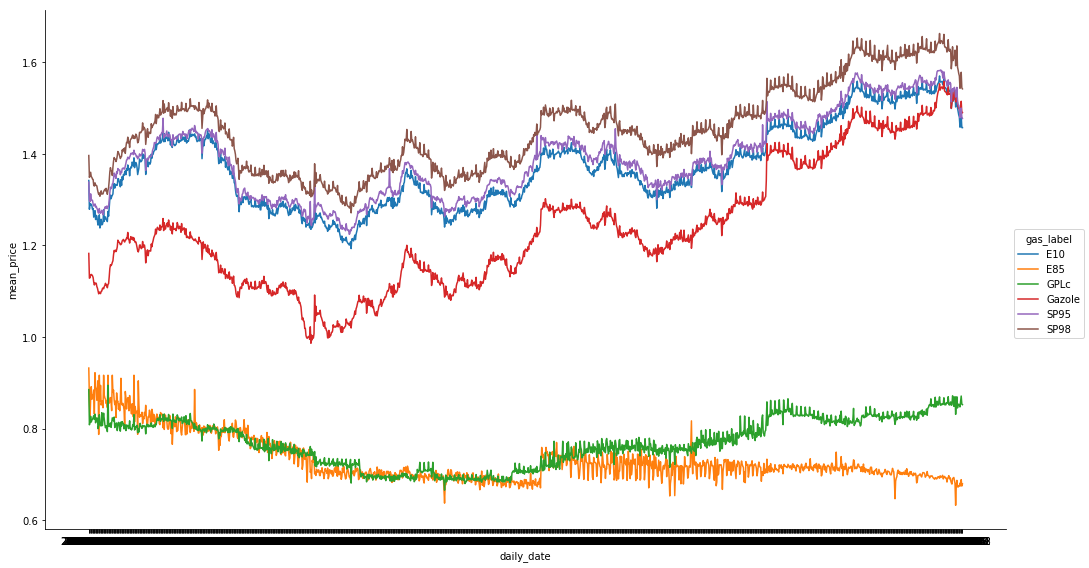

In [44]:
graph = sns.FacetGrid(pnew_df.sort_values(by=['gas_label', 'daily_date']), hue='gas_label', size=8, aspect=16/9)
graph.map(plt.plot, "daily_date", "mean_price")
graph.add_legend()

In [43]:
prix_df1=spark.sql(
    'SELECT distinct gas_label, daily_date, mean_price, price, id_unique, type_pop, gas_type, price_index, latitude, longitude '
    'FROM prix_df '
    'WHERE gas_label is not null AND gas_label="SP98" AND id_unique=6530004 '
    'ORDER BY daily_date, gas_label '
    
).dropna().cache()

After selecting exactly what is wanted in a new table we compute lag variables.

In [44]:
from pyspark.sql.window import Window

In [45]:
partition = Window.partitionBy().orderBy("id_unique","gas_label","daily_date")

In [46]:
prix_df1=prix_df1.withColumn("price1", pyspark.sql.functions.lag(prix_df.price).over(partition))

In [47]:
prix_df1=prix_df1.withColumn("price2", pyspark.sql.functions.lag(prix_df1.price1).over(partition))

In [48]:
prix_df1=prix_df1.withColumn("price3", pyspark.sql.functions.lag(prix_df1.price2).over(partition))

In [49]:
prix_df1=prix_df1.withColumn("price4", pyspark.sql.functions.lag(prix_df1.price3).over(partition))

In [50]:
prix_df1=prix_df1.withColumn("price5", pyspark.sql.functions.lag(prix_df1.price4).over(partition))

In [51]:
prix_df1=prix_df1.withColumn("price6", pyspark.sql.functions.lag(prix_df1.price5).over(partition))

In [52]:
prix_df1=prix_df1.withColumn("price7", pyspark.sql.functions.lag(prix_df1.price6).over(partition))

In [53]:
prix_df1=prix_df1.withColumn("price8", pyspark.sql.functions.lag(prix_df1.price7).over(partition))

In [54]:
prix_df1=prix_df1.withColumn("price9", pyspark.sql.functions.lag(prix_df1.price8).over(partition))

In [55]:
prix_df1=prix_df1.withColumn("price10", pyspark.sql.functions.lag(prix_df1.price9).over(partition))

In [56]:
prix_df1=prix_df1.withColumn("price11", pyspark.sql.functions.lag(prix_df1.price10).over(partition))

In [57]:
prix_df1.printSchema()

root
 |-- gas_label: string (nullable = true)
 |-- daily_date: string (nullable = true)
 |-- mean_price: double (nullable = true)
 |-- price: double (nullable = true)
 |-- id_unique: integer (nullable = true)
 |-- type_pop: string (nullable = true)
 |-- gas_type: integer (nullable = true)
 |-- price_index: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- price1: double (nullable = true)
 |-- price2: double (nullable = true)
 |-- price3: double (nullable = true)
 |-- price4: double (nullable = true)
 |-- price5: double (nullable = true)
 |-- price6: double (nullable = true)
 |-- price7: double (nullable = true)
 |-- price8: double (nullable = true)
 |-- price9: double (nullable = true)
 |-- price10: double (nullable = true)
 |-- price11: double (nullable = true)



# Linear regression. #

In [58]:
from sklearn.model_selection import train_test_split
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

For the linear regression we create a vector of lag variables which is our explanatory one.  

In [106]:
vectorAssembler = VectorAssembler(inputCols = ["price1", "price2", "price3", "price4", "price5", "price6", "price7", "price8", "price9", "price10","price11"], outputCol = 'features')

In [107]:
vprix_df1 = vectorAssembler.transform(prix_df1)

In [108]:
vprix_df1 = vprix_df1.select(['features', 'price'])

In [108]:
vprix_df1.show(3)

We select our train and test samples.

In [109]:
splits = vprix_df1.randomSplit([0.7, 0.3])

In [110]:
train_df = splits[0]

In [111]:
test_df = splits[1]

In [112]:
lr = LinearRegression(featuresCol = 'features', labelCol='price', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [115]:
lr_model = lr.fit(train_df)

We represent our predictions.

In [ ]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

In [ ]:
train_df.describe().show()

In [ ]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

In [ ]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

In [ ]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

In [ ]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","price","features").show()

# Random forest regression. #

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [48]:
(trainingData, testData) = df2.randomSplit([0.7, 0.3])

In [49]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol='price')

In [ ]:
pipeline = Pipeline(stages=[featureIndexer, rf])

In [ ]:
model = pipeline.fit(trainingData)

In [136]:
predictions = model.transform(testData)

In [ ]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Bonus question (downloading files from GitHub).

In [ ]:
import urllib.request

In [ ]:
url = 'https://github.com/rvm-course/GasPrices/blob/master/Prix2007.zip'

In [ ]:
urllib.request.urlretrieve(url, 'chemin de destination')